# Advanced Regression Techniques: Cross-Validation and Grid Search

If you have not read [RegressionExplained](RegressionExplained.md) or [HousePrices](HousePrices.ipynb), go and read those posts first. 

In `HousePrices.ipynb`, we built regression models for predicting house prices. Now, let's dive into advanced techniques that help us validate our models more robustly, find optimal model parameters automatically, and ensure our models generalize well to new data.

## Why We Need Advanced Validation Techniques

Our previous approach using a simple train-test split had some limitations:

1. **High Variance in Performance Estimates**
   - Results depend heavily on which data points end up in training vs testing
   - A "lucky" split might make our model look better than it is
   - An "unlucky" split might make us discard a good model

2. **Inefficient Use of Data**
   - Only a portion of data used for training
   - Limited validation feedback
   - Risk of overfitting to validation set

3. **Parameter Selection Challenges** 
   - Manual tuning is time-consuming
   - Hard to find optimal parameters
   - Risk of human bias in selection


## Cross-Validation: A Better Way to Validate Models

### How Cross-Validation Works

Instead of a single train-test split, cross-validation:

1. Splits data into k equal folds

2. Trains k different models where:
   - Each model uses k-1 folds for training
   - Remaining fold used for validation
   - Process repeats k times, using different validation fold each time

### Benefits of Cross-Validation

1. **More Reliable Performance Estimates**
   - You can analyze the mean and standard deviation of performance
   - More confident in model's true capabilities
   - Better handle on model stability

2. **Better Use of Data**
   - Every data point used for both training and validation
   - More training data = better model learning
   - More validation coverage = better performance estimates

3. **Protection Against Overfitting**
   - Multiple validation sets prevent overfitting to any single split
   - More robust model selection
   - Better generalization to new data

## Grid Search: Automated Parameter Optimization

### The Problem with Manual Tuning

When we manually tried different parameters in our previous post:
- Process was time-consuming
- Might have missed optimal combinations
- Difficult to be systematic

### How Grid Search Works

Grid Search automates parameter optimization by:

1. Taking a dictionary of parameter values to try:
   ```python
   param_grid = {
       'max_depth': [3, 5, 7, 10],
       'n_estimators': [100, 200, 300],
       'learning_rate': [0.01, 0.1]
   }
   ```

2. Testing all combinations systematically:
   ```python
   from sklearn.model_selection import GridSearchCV
   
   grid_search = GridSearchCV(
       estimator=model,
       param_grid=param_grid,
       cv=5,    # Cross-Validation for each model
       scoring='neg_mean_squared_error',
       n_jobs=-1
   )
   ```

3. Using cross-validation for each combination
4. Returning the best parameters and model

### Benefits of Grid Search

1. **Systematic Exploration**
   - Tests all parameter combinations
   - No human bias in selection
   - Thorough coverage of parameter space

2. **Time Efficiency**
   - Can run in parallel
   - Automated process
   - No manual intervention needed

3. **Better Results**
   - More likely to find optimal parameters
   - Cross-validated performance for each combination
   - Confidence in parameter selection


## Best Practices and Common Pitfalls

### Do's:
1. **Choose k Wisely**
   - k=5 or k=10 are common choices
   - Larger k = more compute time
   - Smaller k = less reliable estimates

2. **Stratify When Needed**
   - Use stratified k-fold for imbalanced data
   - Maintains class distribution across folds
   - More reliable performance estimates

3. **Parameter Grid Design**
   - Start broad, then refine
   - Use domain knowledge when possible
   - Consider computational resources

### Don'ts:
1. **Avoid Data Leakage**
   - Scale/transform inside cross-validation
   - Don't use test set for parameter tuning
   - Keep validation process independent

2. **Don't Overfit to CV Score**
   - Consider model complexity
   - Look at score variance
   - Balance performance vs. simplicity

3. **Don't Ignore Computational Cost**
   - Grid size grows exponentially
   - Consider random search for large spaces
   - Use reasonable parameter ranges

# Implementing These Techniques

Lets apply these advanced techniques to the same task we were working on in the last blog post: Predicting house prices in California.

**NOTE:** 

We are using a more comprehensive dataset than the previous blog post so we can fully utilize the advantages of cross-validation and grid search.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

## [Ames Housing Dataset:](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

The dataset we're using comes from the "House Prices: Advanced Regression Techniques" Kaggle competition. This dataset goes beyond typical house price datasets by including extensive details about residential properties in Ames, Iowa.

Dataset Quick Attributes:

- Training set: 1,460 houses
- Test set: 1,459 houses
- Target variable: Sale Price
- Features: 79 explanatory variables
- Time period: 2006-2010

### Feature Categories:

**Property Details:**

- Building Type
- Year Built and Remodeled
- Lot Configuration and Size
- Zoning Classification
- Neighborhood

**Interior Features:**

- Room Numbers and Types
- Basement Characteristics
- Kitchen Quality
- Interior Finishes
- Heating/Cooling Systems

**Exterior Features:**

- Foundation Type
- Roof Material and Style
- Exterior Materials
- Garage Details
- Porch/Deck Areas

**Quality Ratings:**

- Overall Material and Finish Quality (1-10)
- Overall Condition Rating (1-10)
- Various Feature Quality Ratings

## Data Preprocessing

Before we can apply our advanced techniques, we need to prepare our data carefully. Let's look at:
1. What features we have
2. Missing values
3. Categorical vs numerical features
4. Feature distributions

In [2]:
# Read the data
data_train = pd.read_csv("housing_train.csv")
data_test = pd.read_csv("housing_test.csv")
data_test_y = pd.read_csv("housing_test_y.csv")

# Combine Input and Output for the testing data
# We need to combine for the TEST set so we know if the model was correct
data_test['SalePrice']=data_test_y['SalePrice']

# Label train and test data
data_train['train']=1
data_test['train']=0

# Combine train and test data
data = pd.concat([data_train, data_test], axis=0, sort=False)

### Understanding the Features

Lets do some exploratory data analysis so we can better understand what we are working with.

In [3]:
# Basic data information
print('data_train.shape', data_train.shape)
print('data_test.shape', data_test.shape)
print('data.shape', data.shape)

data_train.shape (1460, 82)
data_test.shape (1459, 82)
data.shape (2919, 82)


In [4]:
# Display feature information
print("\nFeature Types:")
print(data_train.dtypes.value_counts())


Feature Types:
object     43
int64      36
float64     3
Name: count, dtype: int64


### Understanding Our Features
 
Let's look at what types of features we're working with:

In [5]:
# Get list of numerical and categorical features
numerical_cols = data.select_dtypes(include=[np.number]).columns
categorical_cols = data.select_dtypes(exclude=[np.number]).columns

print("\nSample of numerical features:")
print(numerical_cols[:10].tolist())

print("\nSample of categorical features:")
print(categorical_cols[:10].tolist())


Sample of numerical features:
['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1']

Sample of categorical features:
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1']


### Analyzing Missing Values
 
Missing values can significantly impact our model's performance. Let's see what we're dealing with:

In [6]:
# Calculate missing values
missing = pd.concat([
data.isnull().sum(),
(data.isnull().sum() / len(data) * 100)
], axis=1)

# Rename columns
missing.columns = ['Count', 'Percentage']
missing = missing[missing['Count'] > 0].sort_values('Percentage', ascending=False)

# Display missing values
print("Features with missing values:")
print(missing)

Features with missing values:
              Count  Percentage
PoolQC         2909   99.657417
MiscFeature    2814   96.402878
Alley          2721   93.216855
Fence          2348   80.438506
MasVnrType     1766   60.500171
FireplaceQu    1420   48.646797
LotFrontage     486   16.649538
GarageFinish    159    5.447071
GarageQual      159    5.447071
GarageCond      159    5.447071
GarageYrBlt     159    5.447071
GarageType      157    5.378554
BsmtExposure     82    2.809181
BsmtCond         82    2.809181
BsmtQual         81    2.774923
BsmtFinType2     80    2.740665
BsmtFinType1     79    2.706406
MasVnrArea       23    0.787941
MSZoning          4    0.137033
BsmtFullBath      2    0.068517
BsmtHalfBath      2    0.068517
Functional        2    0.068517
Utilities         2    0.068517
GarageArea        1    0.034258
GarageCars        1    0.034258
Electrical        1    0.034258
KitchenQual       1    0.034258
TotalBsmtSF       1    0.034258
BsmtUnfSF         1    0.034258
BsmtFinSF2

<Axes: xlabel='None', ylabel='None'>

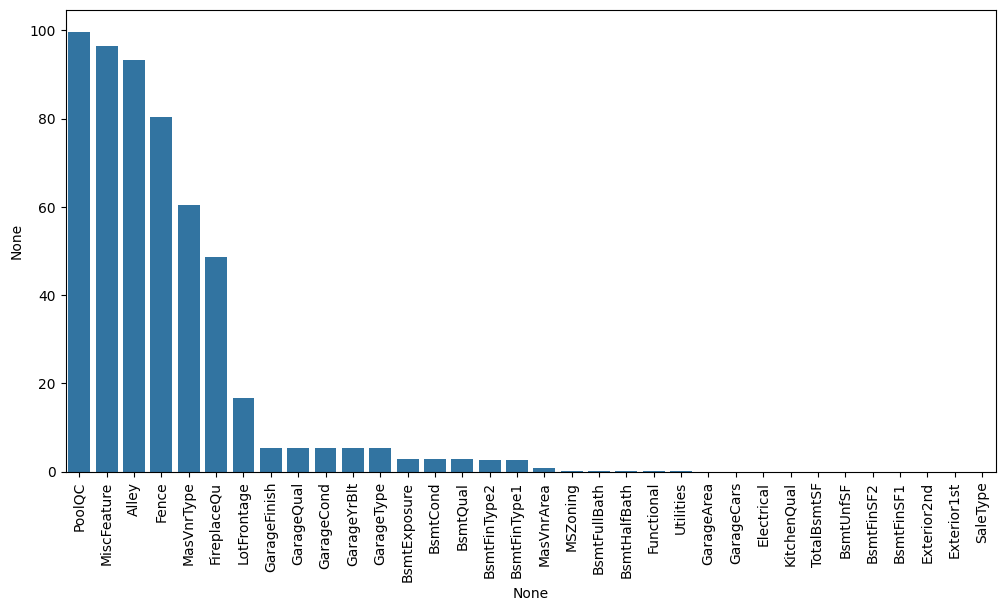

In [7]:
# Show the missing values in a plot
data_missing = (data.isnull().sum(axis=0)/data.shape[0]) * 100
data_missing = data_missing.drop(data_missing[data_missing == 0].index).sort_values(ascending=False)
plt.figure(figsize=(12, 6))
plt.xticks(rotation=90)
sns.barplot(x=data_missing.index, y=data_missing)

### Handling Missing Values
 
We'll use different strategies for different types of missing values:
1. Drop features with too many missing values (>50%)
2. For numerical features: use median imputation
3. For categorical features: create a new 'missing' category

In [8]:
# Drop features with more than 50% missing values
feature_drop = data_missing[data_missing >=50].index
data=data.drop(columns=feature_drop)

print("\nFeatures with more than 50% missing values:")
print(feature_drop)


Features with more than 50% missing values:
Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType'], dtype='object')


In [9]:
# Handle remaining missing values
for column in data.columns:
    if column not in ['train', 'SalePrice']:  # Skip these columns
        if data[column].dtype == np.dtype('O'):  # Categorical
            data[column] = data[column].fillna('missing')
        else:  # Numerical
            valid_values = data[data[column].notnull()][column]
            data[column] = data[column].fillna(valid_values.median())

# Verify no missing values remain
print("\nMissing values after handling:")
print(data.isnull().sum().sum())


Missing values after handling:
0


### Converting Categorical Features
 
Most machine learning models can only work with numbers, not text categories. For example, we have a feature 'ocean_proximity' with categories like 'NEAR BAY' and 'INLAND'. We can't just convert these to numbers 1 and 2

That would imply 'INLAND' is twice as much as 'NEAR BAY', which makes no sense.
 
One-hot encoding solves this by:

1. Creating a new column for each category
2. Putting 1 in the column if the data point belongs to that category
3. Putting 0 in all other category columns
 
Example:

Original:                 After One-Hot Encoding:
ocean_proximity          ocean_NEAR_BAY  ocean_INLAND
NEAR BAY         →            1              0
INLAND           →            0              1
NEAR BAY         →            1              0


In [10]:
# Find categorical columns (excluding target and train indicator)
categorical_columns = data.select_dtypes(include=['object']).columns

# Apply one-hot encoding
data = pd.get_dummies(data, columns=categorical_columns)
print("Shape after one-hot encoding:", data.shape)

Shape after one-hot encoding: (2919, 292)


The Table now has many new columns. These new columns were the category titles from the categorical variables.

In [11]:
data.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_missing,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,...,False,False,True,False,False,False,False,False,True,False
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,...,False,False,True,False,False,False,False,False,True,False
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,...,False,False,True,False,False,False,False,False,True,False
3,4,70,60.0,9550,7,5,1915,1970,0.0,216.0,...,False,False,True,False,True,False,False,False,False,False
4,5,60,84.0,14260,8,5,2000,2000,350.0,655.0,...,False,False,True,False,False,False,False,False,True,False


### Preparing Training and Testing Sets
 
Now we can split our preprocessed data back into training and testing sets:

In [12]:
# Split back into train and test
data_train_processed = data[data['train'] == 1]
data_test_processed = data[data['train'] == 0]

# Separate features and target
X_train = data_train_processed.drop(['SalePrice', 'train'], axis=1).values
y_train = data_train_processed['SalePrice'].values

# Separate features and target for the test set
X_test = data_test_processed.drop(['SalePrice', 'train'], axis=1).values
y_test = data_test_processed['SalePrice'].values

print("Final training set shape:", X_train.shape)
print("Final test set shape:", X_test.shape)

Final training set shape: (1460, 290)
Final test set shape: (1459, 290)


## Implementing Cross-Validation
 
Now that our data is prepared, let's implement cross-validation to get more reliable model performance estimates.

We'll use a custom scoring function that calculates the Mean Absolute Percentage Error (MAPE).

First we need a custom scoring function to measure models' preformances.

In [13]:
def custom_scorer(model, X, y):
    """
    Calculate Mean Absolute Percentage Error (MAPE)
    Lower values are better, so we return negative MAPE
    """
    y_pred = model.predict(X)
    mape = np.mean(np.abs((y - y_pred) / y))
    return -mape  # Negative because GridSearchCV maximizes score

### Using Cross-Validation to Assess Preformance

Let's start with a simple linear regression model:

In [14]:
model = LinearRegression()
scores = cross_val_score(model, X_train, y_train, 
                        scoring=custom_scorer,
                        cv=5)

print("Cross-validation scores (MAPE):")
for fold, score in enumerate(scores, 1):
    print(f"Fold {fold}: {-score*100:.2f}%")
print(f"\nAverage MAPE: {-scores.mean()*100:.2f}% (+/- {scores.std()*100*2:.2f}%)")

Cross-validation scores (MAPE):
Fold 1: 11.16%
Fold 2: 12.10%
Fold 3: 11.17%
Fold 4: 10.18%
Fold 5: 11.33%

Average MAPE: 11.19% (+/- 1.23%)


## Grid Search Implementation
 
Let's implement grid search for our different models. We'll start with a simpler example using Random Forest and then move to more complex models.

### Random Forest with Grid Search

In [15]:
# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [100, 200]
}

# Initialize model
rf_model = RandomForestRegressor(random_state=42)

# Perform grid search
grid_search = GridSearchCV(
    rf_model, param_grid, 
    cv=5, scoring=custom_scorer,
    n_jobs=-1  # Use all available cores
)

grid_search.fit(X_train, y_train)

# Print results
print("Best parameters:", grid_search.best_params_)
print("Best MAPE: {:.2f}%".format(-grid_search.best_score_ * 100))

Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best MAPE: 10.35%


### Visualizing Grid Search Results
 
Let's visualize how different parameters affect model performance:

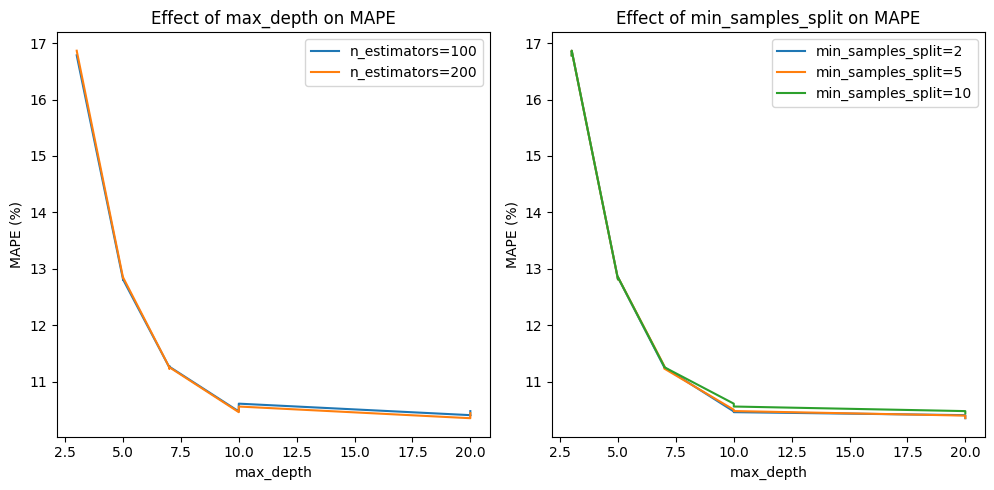

In [16]:
# Convert results to DataFrame for easier analysis
results = pd.DataFrame(grid_search.cv_results_).infer_objects()

# Plot effect of max_depth
plt.figure(figsize=(15, 5))

plt.subplot(131)
for n_est in param_grid['n_estimators']:
    mask = results['param_n_estimators'] == n_est
    plt.plot(results[mask]['param_max_depth'].fillna(20),
             -results[mask]['mean_test_score'] * 100,
             label=f'n_estimators={n_est}')
plt.xlabel('max_depth')
plt.ylabel('MAPE (%)')
plt.legend()
plt.title('Effect of max_depth on MAPE')

plt.subplot(132)
for split in param_grid['min_samples_split']:
    mask = results['param_min_samples_split'] == split
    plt.plot(results[mask]['param_max_depth'].fillna(20),
             -results[mask]['mean_test_score'] * 100,
             label=f'min_samples_split={split}')
plt.xlabel('max_depth')
plt.ylabel('MAPE (%)')
plt.legend()
plt.title('Effect of min_samples_split on MAPE')

plt.tight_layout()
plt.show()

### Final Model Evaluation
 
Let's evaluate our best model on the test set:

In [17]:
best_model = grid_search.best_estimator_

# Make predictions
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Calculate metrics
train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

print(f"Training MAPE: {train_mape:.2f}%")
print(f"Test MAPE: {test_mape:.2f}%")

Training MAPE: 3.76%
Test MAPE: 6.04%


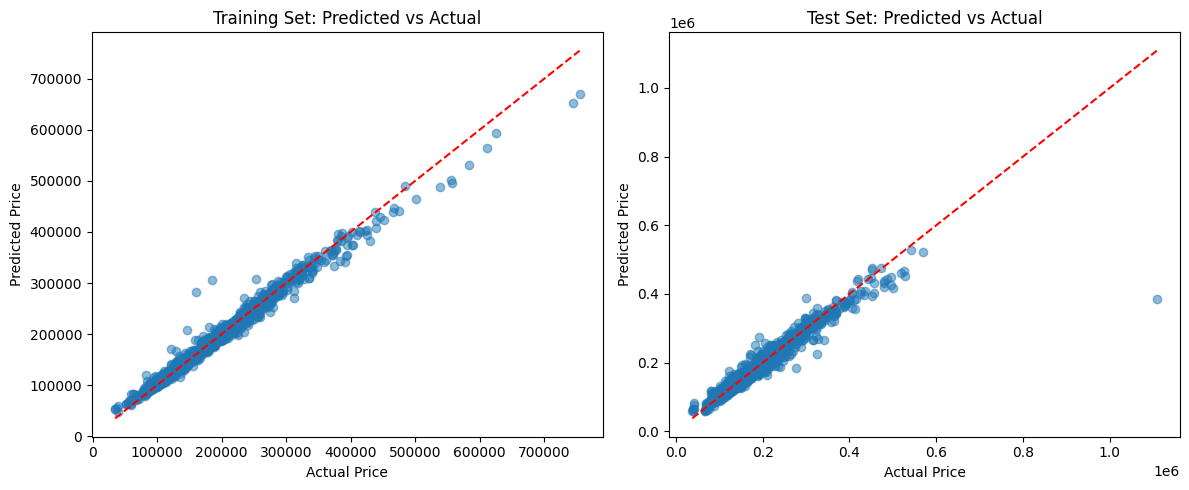

In [18]:
# Plot predictions vs actual
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Training Set: Predicted vs Actual')

plt.subplot(122)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Test Set: Predicted vs Actual')

plt.tight_layout()
plt.show()

### Feature Importance Analysis

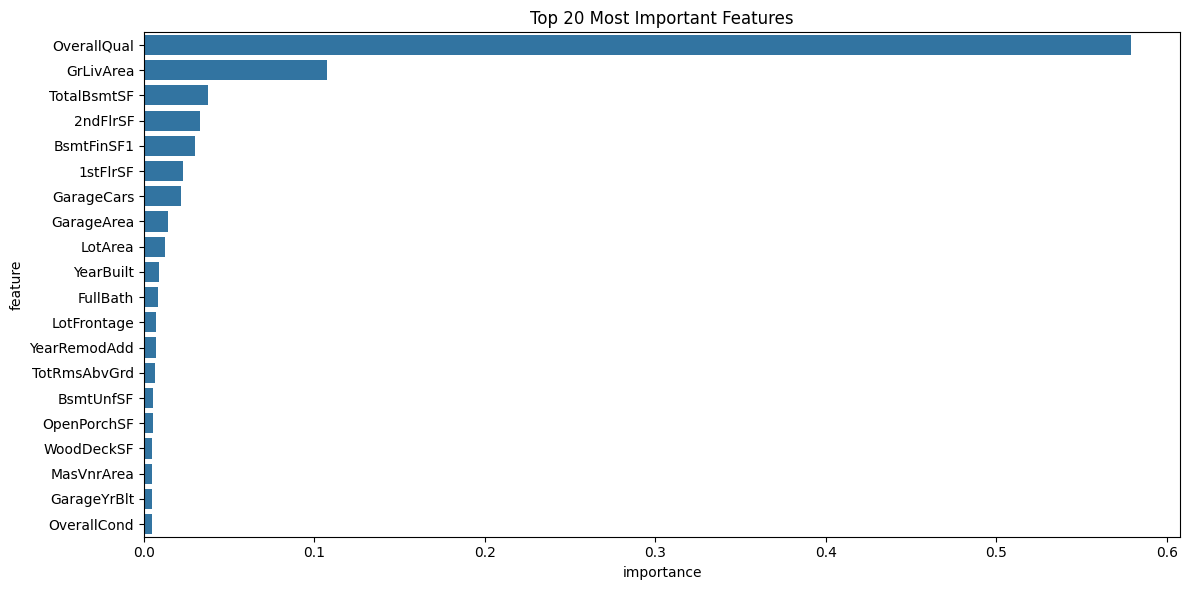

In [19]:
importance = pd.DataFrame({
    'feature': data_train_processed.drop(['SalePrice', 'train'], axis=1).columns,
    'importance': best_model.feature_importances_
})
importance = importance.sort_values('importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=importance.head(20))
plt.title('Top 20 Most Important Features')
plt.tight_layout()
plt.show()

## Applying CV and Grid Search to The Other Models
Now, lets repeat the process for our other models. I won't go into too much detail about these models in this post, as we are focusing on how CV and Grid Search improve them. If you want a deeper dive on the models themselves, read [HousePrices](HousePrices.ipynb)

### K-Nearest Neighbors

In [20]:
# Define parameter grid for KNN
knn_param_grid = {
    'n_neighbors': range(1, 31, 2),  # Test odd numbers up to 30
    'weights': ['uniform', 'distance']  # Try different weighting methods
}

# Initialize KNN model
knn_model = KNeighborsRegressor()

# Perform grid search
knn_grid = GridSearchCV(
    knn_model, 
    knn_param_grid,
    cv=5,
    scoring=custom_scorer,
    n_jobs=-1
)

knn_grid.fit(X_train, y_train)

print("Best KNN Parameters:", knn_grid.best_params_)
print("Best MAPE: {:.2f}%".format(-knn_grid.best_score_ * 100))

Best KNN Parameters: {'n_neighbors': 9, 'weights': 'distance'}
Best MAPE: 17.52%


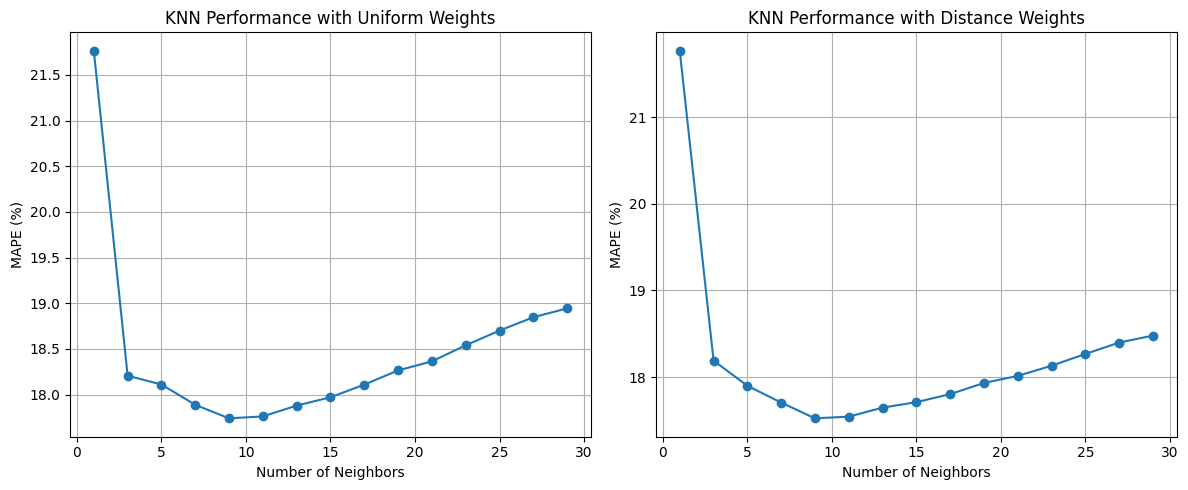

In [21]:
# Extract results for visualization
knn_results = pd.DataFrame(knn_grid.cv_results_)

plt.figure(figsize=(12, 5))

# Plot for uniform weights
uniform_mask = knn_results['param_weights'] == 'uniform'
plt.subplot(121)
plt.plot(knn_results[uniform_mask]['param_n_neighbors'], 
         -knn_results[uniform_mask]['mean_test_score'] * 100,
         'o-', label='Uniform weights')
plt.xlabel('Number of Neighbors')
plt.ylabel('MAPE (%)')
plt.title('KNN Performance with Uniform Weights')
plt.grid(True)

# Plot for distance weights
distance_mask = knn_results['param_weights'] == 'distance'
plt.subplot(122)
plt.plot(knn_results[distance_mask]['param_n_neighbors'], 
         -knn_results[distance_mask]['mean_test_score'] * 100,
         'o-', label='Distance weights')
plt.xlabel('Number of Neighbors')
plt.ylabel('MAPE (%)')
plt.title('KNN Performance with Distance Weights')
plt.grid(True)

plt.tight_layout()
plt.show()

### XGBoost

In [22]:
# Define parameter grid for XGBoost
xgb_param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]  # Try using different portions of data for each tree
}

# Initialize XGBoost model
xgb_model = XGBRegressor(
    objective='reg:squarederror',  # For regression tasks
    random_state=42
)

# Perform grid search
xgb_grid = GridSearchCV(
    xgb_model,
    xgb_param_grid,
    cv=5,
    scoring=custom_scorer,
    n_jobs=-1
)

xgb_grid.fit(X_train, y_train)

print("Best XGBoost Parameters:", xgb_grid.best_params_)
print("Best MAPE: {:.2f}%".format(-xgb_grid.best_score_ * 100))

Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best MAPE: 8.92%


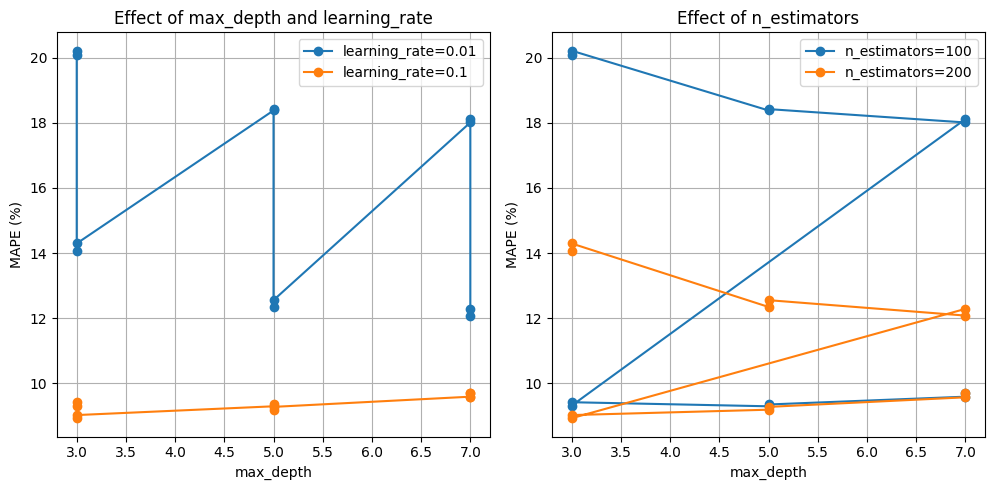

In [23]:
xgb_results = pd.DataFrame(xgb_grid.cv_results_)

plt.figure(figsize=(15, 5))

# Plot effect of max_depth for different learning rates
plt.subplot(131)
for lr in xgb_param_grid['learning_rate']:
    mask = xgb_results['param_learning_rate'] == lr
    plt.plot(xgb_results[mask]['param_max_depth'],
             -xgb_results[mask]['mean_test_score'] * 100,
             'o-', label=f'learning_rate={lr}')
plt.xlabel('max_depth')
plt.ylabel('MAPE (%)')
plt.title('Effect of max_depth and learning_rate')
plt.legend()
plt.grid(True)

# Plot effect of n_estimators
plt.subplot(132)
for n_est in xgb_param_grid['n_estimators']:
    mask = xgb_results['param_n_estimators'] == n_est
    plt.plot(xgb_results[mask]['param_max_depth'],
             -xgb_results[mask]['mean_test_score'] * 100,
             'o-', label=f'n_estimators={n_est}')
plt.xlabel('max_depth')
plt.ylabel('MAPE (%)')
plt.title('Effect of n_estimators')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

This is a confusing graph. It is comparing different values of learning rate and n_estimators against max depth. There is no direct comparison between learning_rate and n_estimators themselves. This is just supposed to help give you an idea of how parameters can impact model preformance.

## Model Comparison
 
Now let's compare all our models (Linear Regression, Random Forest, KNN, and XGBoost) on the test set. It will be interesting to see how these results compare to my previous post, where I optimized parameters by hand. Will we get a new best model?

In [24]:
# Add Linear Regression to our models
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

models = {
    'Linear Regression': linear_model,
    'KNN': knn_grid.best_estimator_,
    'Random Forest': grid_search.best_estimator_,
    'XGBoost': xgb_grid.best_estimator_
}

In [25]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Evaluate a model and return various performance metrics
    """
    # Time the predictions
    from time import time
    
    # Training predictions and metrics
    train_start = time()
    y_train_pred = model.predict(X_train)
    train_time = time() - train_start
    
    train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
    train_r2 = model.score(X_train, y_train)
    
    # Test predictions and metrics
    test_start = time()
    y_test_pred = model.predict(X_test)
    test_time = time() - test_start
    
    test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
    test_r2 = model.score(X_test, y_test)
    
    return {
        'Model': model_name,
        'Train MAPE': train_mape,
        'Test MAPE': test_mape,
        'Train R^2': train_r2,
        'Test R^2': test_r2,
        'Prediction Time': test_time,
        'Test Predictions': y_test_pred
    }

In [26]:
# Evaluate all models
results = []
for name, model in models.items():
    result = evaluate_model(model, X_train, X_test, y_train, y_test, name)
    results.append(result)

# Create comparison DataFrame
comparison_df = pd.DataFrame(results)
comparison_df = comparison_df.drop('Test Predictions', axis=1)  # Drop predictions for display
print("\nModel Performance Comparison:")
print(comparison_df.round(3))


Model Performance Comparison:
               Model  Train MAPE  Test MAPE  Train R^2  Test R^2  \
0  Linear Regression       7.909      7.300      0.931     0.931   
1                KNN       0.000     17.318      1.000     0.636   
2      Random Forest       3.761      6.044      0.981     0.911   
3            XGBoost       5.440      4.187      0.978     0.912   

   Prediction Time  
0            0.012  
1            0.018  
2            0.035  
3            0.008  


### Visualizing Model Predictions
 
Let's compare how each model's predictions align with actual values:

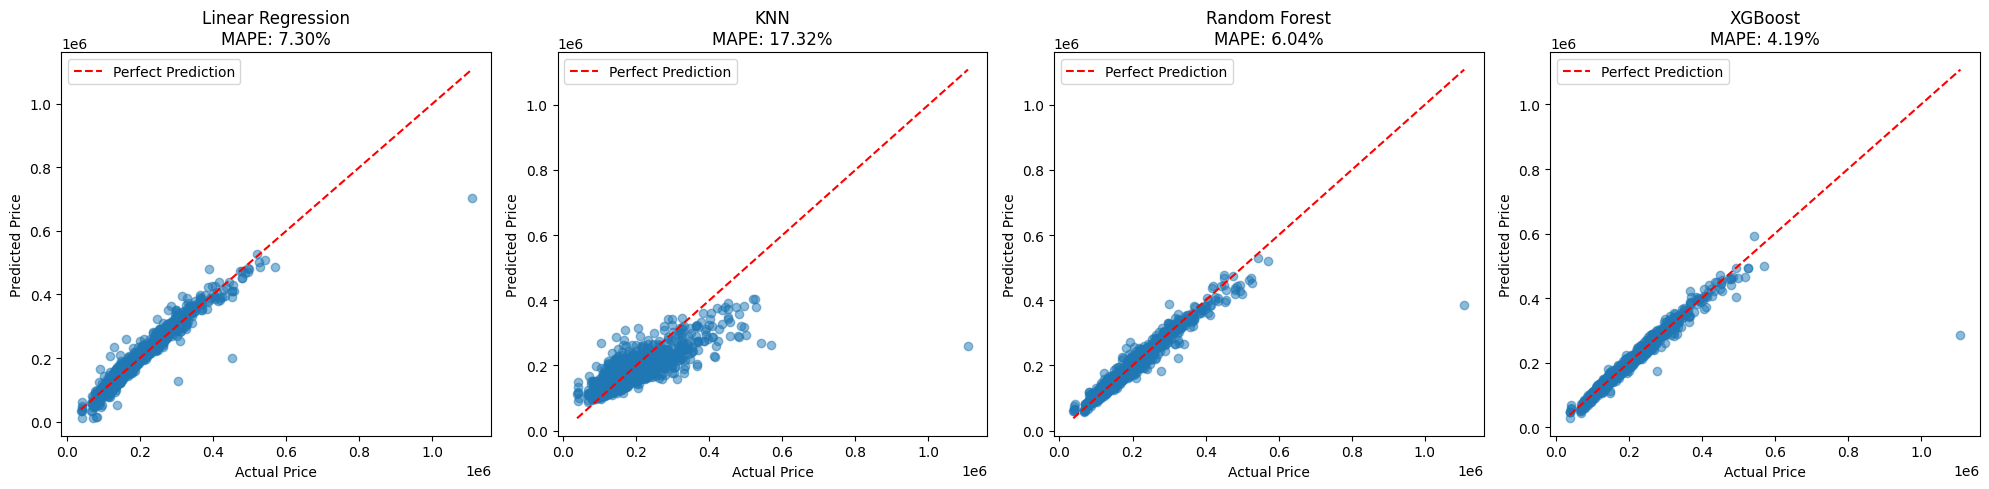

In [27]:
plt.figure(figsize=(20, 5))

for i, (name, model) in enumerate(models.items()):
    plt.subplot(1, 4, i+1)
    y_pred = model.predict(X_test)
    
    # Calculate MAPE for this model
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], 
             [y_test.min(), y_test.max()], 
             'r--', label='Perfect Prediction')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title(f'{name}\nMAPE: {mape:.2f}%')
    plt.legend()

plt.tight_layout()
plt.show()

### Error Distribution Analysis
 
Let's examine how prediction errors are distributed for each model:

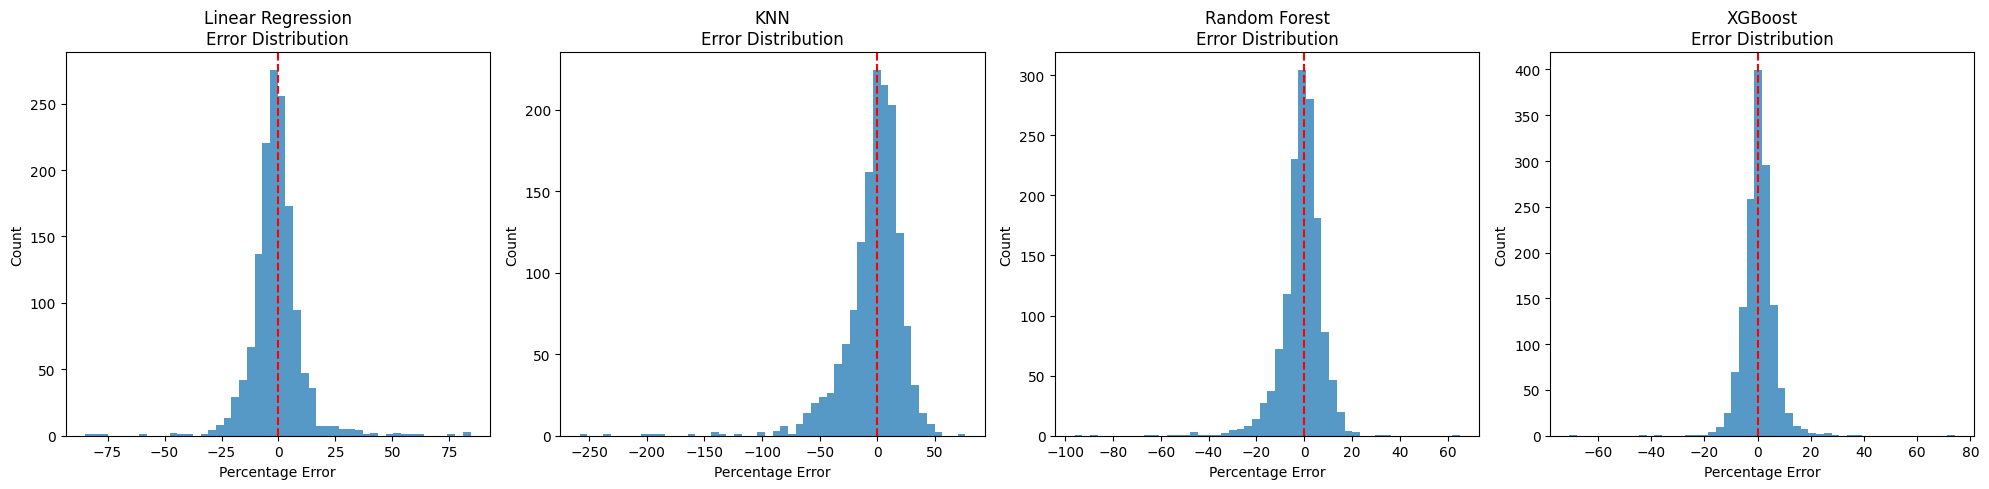

In [28]:
plt.figure(figsize=(20, 5))

for i, (name, model) in enumerate(models.items()):
    plt.subplot(1, 4, i+1)
    y_pred = model.predict(X_test)
    
    # Calculate percentage errors
    errors = ((y_test - y_pred) / y_test) * 100
    
    # Plot error distribution
    plt.hist(errors, bins=50, alpha=0.75)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.xlabel('Percentage Error')
    plt.ylabel('Count')
    plt.title(f'{name}\nError Distribution')

plt.tight_layout()
plt.show()

### Price Range Analysis
 
Let's see how models perform across different price ranges:

In [29]:
def calculate_mape_by_price_range(y_true, y_pred, bins=5):
    # Create price ranges
    price_ranges = pd.qcut(y_true, bins)
    
    # Calculate MAPE for each range
    mapes = []
    for price_range in price_ranges.unique():
        mask = price_ranges == price_range
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
        mapes.append({
            'Price Range': f'${price_range.left:,.0f} - ${price_range.right:,.0f}',
            'MAPE': mape
        })
    
    return pd.DataFrame(mapes)

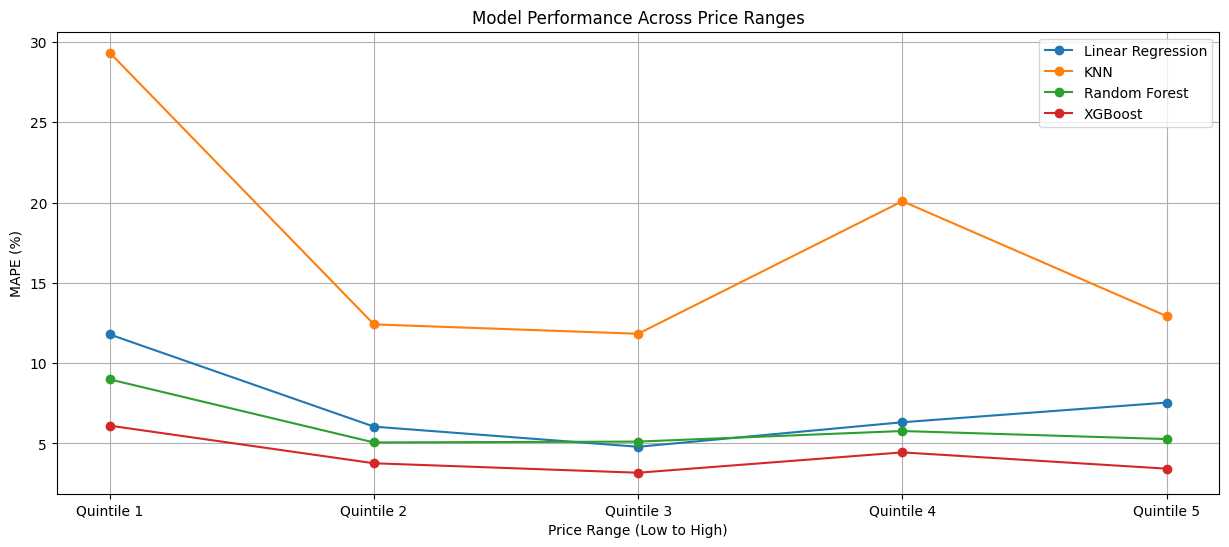

In [30]:
plt.figure(figsize=(15, 6))

# Calculate and plot MAPE by price range for each model
for name, model in models.items():
    y_pred = model.predict(X_test)
    mapes_by_range = calculate_mape_by_price_range(y_test, y_pred)
    plt.plot(range(len(mapes_by_range)), mapes_by_range['MAPE'], 'o-', label=name)

plt.xlabel('Price Range (Low to High)')
plt.ylabel('MAPE (%)')
plt.title('Model Performance Across Price Ranges')
plt.legend()
plt.grid(True)
plt.xticks(range(5), [f'Quintile {i+1}' for i in range(5)])
plt.show()

### Key Insights from Model Comparison:
 
1. **Overall Performance**
    - Linear Regression provides a decent baseline
    - More complex models show incremental improvements
    - XGBoost generally performs best but with higher complexity
 
2. **Error Patterns**
    - All models struggle more with high-priced houses
    - Linear Regression shows more systematic errors
    - Advanced models better capture non-linear relationships
 
3. **Trade-offs**
    - Linear Regression: Fast, interpretable, but less accurate
    - KNN: Simple, no training time, but slower predictions
    - Random Forest: Good balance of accuracy and interpretability
    - XGBoost: Most accurate but requires more tuning
 
4. **Recommendations**
    - For quick insights: Use Linear Regression
    - For balanced performance: Use Random Forest
    - For maximum accuracy: Use XGBoost
    - For small datasets: Consider KNN